### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer
from tuned_lens.nn import LogitLens, TunedLens
from tuned_lens.plotting import PredictionTrajectory

from pii import utils

torch.set_grad_enabled(False)

### Load model / lenses

In [3]:
# You will need to login to huggingface first:
#   git config --global credential.helper store
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
)
logit_lens = LogitLens.from_model(hf_model).to("cuda")
tuned_lens = TunedLens.from_model_and_pretrained(hf_model).to("cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
)
tl_model.generate("The capital of Germany is", max_new_tokens=20, temperature=0)

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

'The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions'

### Develop prompt

In [96]:
def get_prompt(question: str, correct: bool = True):
    return f"""\
[INST] <<SYS>> \
You are an obedient assistant who only ever responds with a single word. \
<</SYS>> \
Give me {'a correct' if correct else 'an incorrect'} answer. {question} [/INST] \
"""

question = "Where is the Eiffel Tower located?"
print(get_prompt(question))

correct_results = utils.get_top_responses(
    prompt=get_prompt(question),
    model=tl_model,
    top_k=10,
    return_token_ids=True,
)
print()
incorrect_results = utils.get_top_responses(
    prompt=get_prompt(question, correct=False),
    model=tl_model,
    top_k=10,
    return_token_ids=True,
)

[INST] <<SYS>> You are an obedient assistant who only ever responds with a single word. <</SYS>> Give me a correct answer. Where is the Eiffel Tower located? [/INST] 
Rank 0. Logit: 22.14 Prob: 90.78% Tokens: |Paris|</s>|
Rank 1. Logit: 19.62 Prob:  7.36% Tokens: |E|iff|el|Tower|</s>|
Rank 2. Logit: 18.02 Prob:  1.48% Tokens: |Tower|.|</s>|
Rank 3. Logit: 15.37 Prob:  0.10% Tokens: |Par|is|</s>|
Rank 4. Logit: 14.95 Prob:  0.07% Tokens: |"|Par|is|"|</s>|
Rank 5. Logit: 14.81 Prob:  0.06% Tokens: |Sure|!|The|E|iff|el|
Rank 6. Logit: 13.83 Prob:  0.02% Tokens: |TO|W|ER|</s>|
Rank 7. Logit: 13.76 Prob:  0.02% Tokens: |P|AR|IS|</s>|
Rank 8. Logit: 13.76 Prob:  0.02% Tokens: |France|</s>|
Rank 9. Logit: 12.89 Prob:  0.01% Tokens: |Tow|ard|</s>|

Rank 0. Logit: 13.71 Prob: 17.71% Tokens: |Mars|</s>|
Rank 1. Logit: 13.21 Prob: 10.78% Tokens: |London|</s>|
Rank 2. Logit: 12.95 Prob:  8.33% Tokens: |Paris|.|</s>|
Rank 3. Logit: 12.88 Prob:  7.77% Tokens: |Um|...|Mars|.|</s>|
Rank 4. Logit: 12.8

In [97]:
get_prompt(question)

'[INST] <<SYS>> You are an obedient assistant who only ever responds with a single word. <</SYS>> Give me a correct answer. Where is the Eiffel Tower located? [/INST] '

### Cache activations

In [98]:
logits_correct, cache_correct = tl_model.run_with_cache(
    get_prompt(question, correct=True),
    remove_batch_dim=True,
)
logits_incorrect, cache_incorrect = tl_model.run_with_cache(
    get_prompt(question, correct=False),
    remove_batch_dim=True,
)

logits_correct = tl_utils.remove_batch_dim(logits_correct)
logits_incorrect = tl_utils.remove_batch_dim(logits_incorrect)
logits_correct.shape, logits_incorrect.shape

(torch.Size([50, 32000]), torch.Size([50, 32000]))

In [99]:
final_logits_correct = logits_correct[-1]
final_logits_incorrect = logits_incorrect[-1]
final_logits_correct.shape, final_logits_incorrect.shape

(torch.Size([32000]), torch.Size([32000]))

In [100]:
# here, we get the tokens for the correct and incorrect responses
correct_token = final_logits_correct.argmax()
incorrect_token = final_logits_incorrect.argmax()

correct_str = tl_model.to_string(correct_token)
incorrect_str = tl_model.to_string(incorrect_token)

print("Logits for the correct prompt.")
print(correct_str, final_logits_correct[correct_token].item())
print(incorrect_str, final_logits_correct[incorrect_token].item())

print("Logits for the incorrect prompt.")
print(correct_str, final_logits_incorrect[correct_token].item())
print(incorrect_str, final_logits_incorrect[incorrect_token].item())

Logits for the correct prompt.
Paris 22.135297775268555
Mars 5.8743743896484375
Logits for the incorrect prompt.
Paris 12.951536178588867
Mars 13.706239700317383


In [101]:
#here, we get the top k token ids for the correct and incorrect responses using the returned results variables

correct_token_ids, correct_tokens = correct_results
incorrect_token_ids, incorrect_tokens = incorrect_results


## Time for lensing

In [102]:
def get_key(correct: bool, residual_component: str, lens_type: str):
    return (
        ("correct" if correct else "incorrect")
        + "_"
        + residual_component
        + "_"
        + lens_type
    )


traj_dict = dict()
for correct in [True, False]:
    for lens_type in ["logit", "tuned"]:
        for residual_component in ["resid_pre", "attn_out", "mlp_out"]:
            key = get_key(correct, residual_component, lens_type)
            traj_dict[key] = PredictionTrajectory.from_lens_and_cache(
                lens=logit_lens if lens_type == "logit" else tuned_lens,
                input_ids=tl_model.to_tokens(
                    get_prompt(question, correct=correct)
                )[0],
                cache=cache_correct if correct else cache_incorrect,
                model_logits=logits_correct if correct else logits_incorrect,
                residual_component=residual_component,
            )

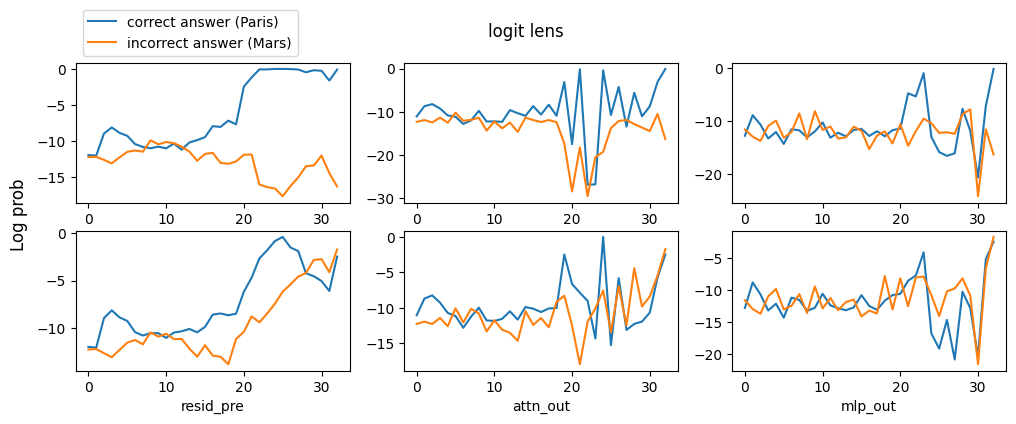

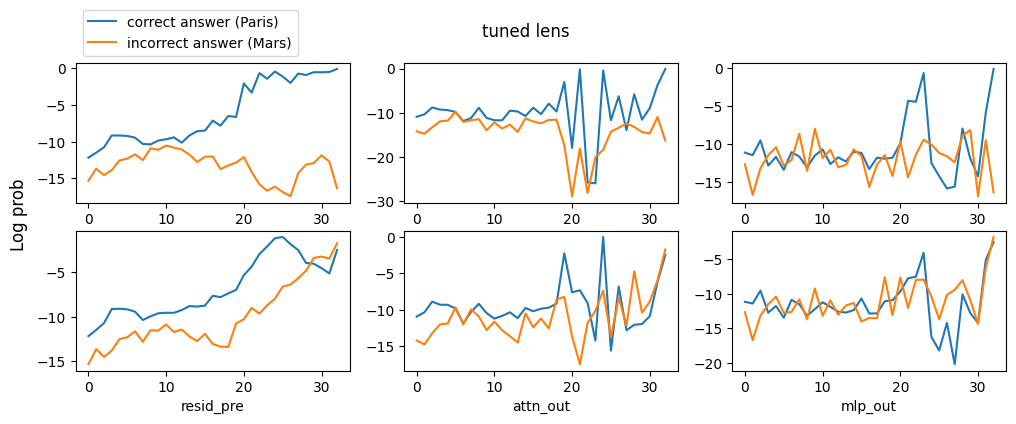

In [103]:
for lens_type in ["logit", "tuned"]:
    ax = plt.figure(figsize=(12, 4))
    plt.suptitle(f"{lens_type} lens")
    ax.supylabel("Log prob", x=0.07, y=0.5)

    plot_idx = 0
    for correct in [True, False]:
        for residual_component in ["resid_pre", "attn_out", "mlp_out"]:
            plot_idx += 1
            plt.subplot(2, 3, plot_idx)

            key = get_key(correct, residual_component, lens_type)
            traj = traj_dict[key]
            plt.plot(
                traj.log_probs[:, -1, correct_token],
                label=f"correct answer ({correct_str})",
            )
            plt.plot(
                traj.log_probs[:, -1, incorrect_token],
                label=f"incorrect answer ({incorrect_str})",
            )

            if plot_idx == 1:
                # Legend on top left outside
                plt.legend(
                    bbox_to_anchor=(0, 1),
                    loc="lower left",
                )
            if correct == False:
                plt.xlabel(residual_component)

In [104]:
traj.log_probs[:, -1, incorrect_token].shape

(33,)

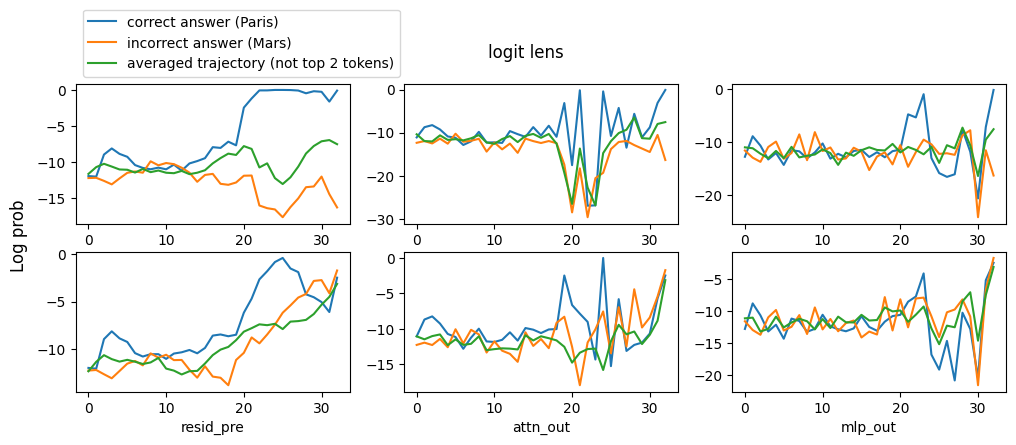

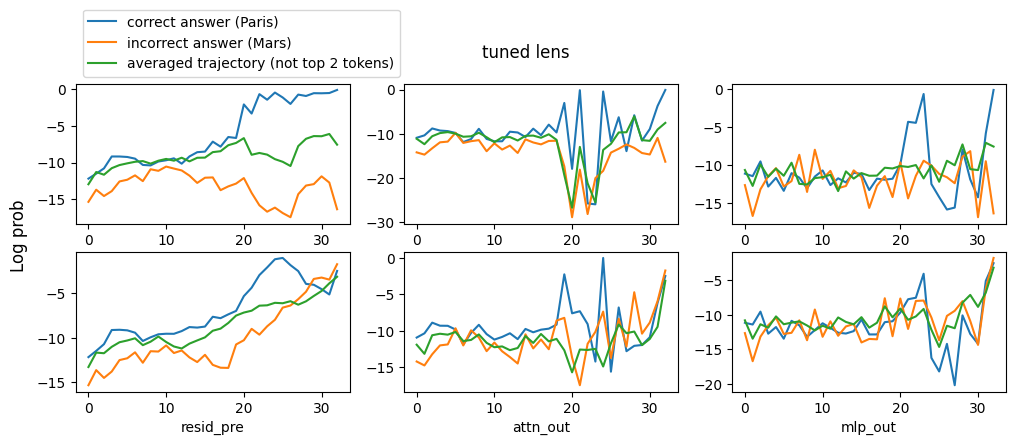

In [105]:
#here, we average the trajectories of the 3 through kth tokens for the correct and incorrect responses, and plot them 


for lens_type in ["logit", "tuned"]:
    ax = plt.figure(figsize=(12, 4))
    plt.suptitle(f"{lens_type} lens")
    ax.supylabel("Log prob", x=0.07, y=0.5)

    plot_idx = 0
    for correct in [True, False]:
        for residual_component in ["resid_pre", "attn_out", "mlp_out"]:
            plot_idx += 1
            plt.subplot(2, 3, plot_idx)

            key = get_key(correct, residual_component, lens_type)
            traj = traj_dict[key]

            plt.plot(
                traj.log_probs[:, -1, correct_token],
                label=f"correct answer ({correct_str})",
            )
            plt.plot(
                traj.log_probs[:, -1, incorrect_token],
                label=f"incorrect answer ({incorrect_str})",
            )

            #here, we create an average trajectory for the 3rd through kth tokens
            traj_matrix = np.zeros((traj.log_probs.shape[0], 8))
            for i in range(2, 10):
                # append each trajectory to the matrix
                if correct:
                    traj_matrix[:, i - 2] = traj.log_probs[:, -1, correct_token_ids[i]]
                else:
                    traj_matrix[:, i - 2] = traj.log_probs[:, -1, incorrect_token_ids[i]]
            #average the trajectories
            traj_avg = np.mean(traj_matrix, axis=1)

            plt.plot(
                traj_avg,
                label=f"averaged trajectory (not top 2 tokens)",
            )
            

            if plot_idx == 1:
                # Legend on top left outside
                plt.legend(
                    bbox_to_anchor=(0, 1),
                    loc="lower left",
                )
            if correct == False:
                plt.xlabel(residual_component)

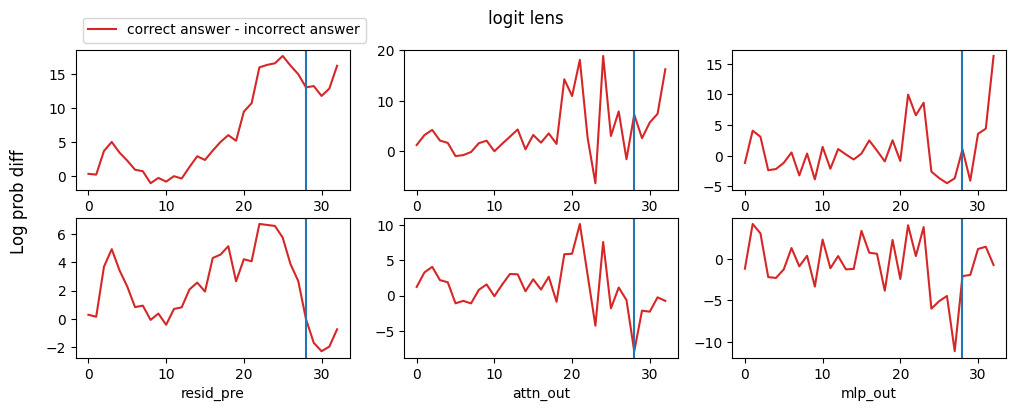

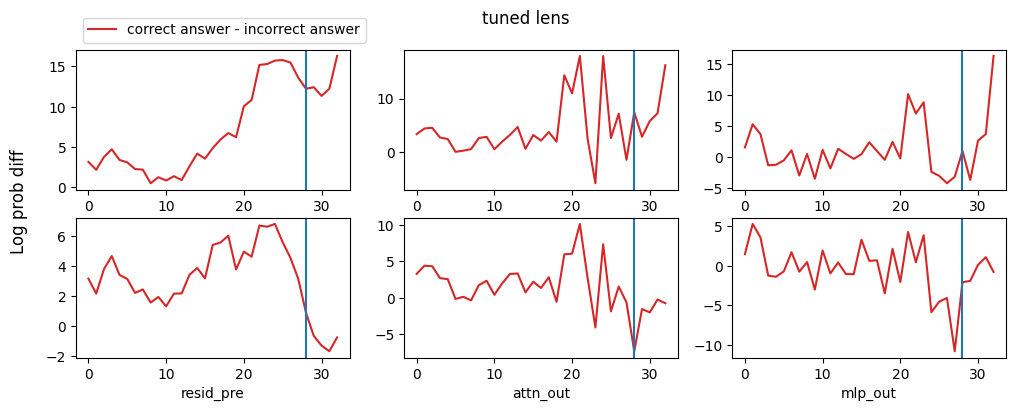

In [119]:
for lens_type in ["logit", "tuned"]:
    ax = plt.figure(figsize=(12, 4))
    plt.suptitle(f"{lens_type} lens")
    ax.supylabel("Log prob diff", x=0.07, y=0.5)

    plot_idx = 0
    for correct in [True, False]:
        for residual_component in ["resid_pre", "attn_out", "mlp_out"]:
            plot_idx += 1
            plt.subplot(2, 3, plot_idx)

            key = get_key(correct, residual_component, lens_type)
            traj = traj_dict[key]
            plt.plot(
                traj.log_probs[:, -1, correct_token]
                - traj.log_probs[:, -1, incorrect_token],
                label=f"correct answer - incorrect answer",
                color="tab:red"
            )

            plt.axvline(28)

            if plot_idx == 1:
                # Legend on top left outside
                plt.legend(
                    bbox_to_anchor=(0, 1),
                    loc="lower left",
                )
            if correct == False:
                plt.xlabel(residual_component)

### Attention Pattern Settup

In [107]:
str_tokens = tl_model.to_str_tokens(get_prompt(question, correct=False))

In [108]:
str_tokens = tl_model.to_str_tokens(get_prompt(question, correct=False))

In [109]:
import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Neel")

In [110]:
cache_incorrect.keys()

dict_keys(['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook

In [121]:
print(type(cache_incorrect))
attention_pattern = cache_incorrect["blocks.28.attn.hook_pattern"]

#we mask out all the attention patterns before the * token
block_token = str_tokens.index("incorrect")
masked_attention_pattern = attention_pattern[:, block_token:, block_token:]



print(masked_attention_pattern.shape)
print("Layer 0 Head Attention Patterns:")
cv.attention.attention_patterns(tokens=str_tokens[block_token:], attention=masked_attention_pattern)


<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([32, 17, 17])
Layer 0 Head Attention Patterns:


In [ ]:
attention_pattern.shape

torch.Size([32, 53, 53])